## Setup:

In [156]:
import os
import json
from pathlib import Path
from collections import Counter
import pandas as pd

# --- CONFIG ---
BASE_PATH = Path("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/llm_subtopic")
MODES = ["single_label", "multi_label"]

# Note: Health becomes part of the Lifestyle
LABEL_MAP = {
    "Health": "Lifestyle"
}



records = []

for mode in MODES:
    mode_path = BASE_PATH / mode
    topic_files = sorted(mode_path.glob("topic_*.json"))
    
    for file in topic_files:
        with open(file, "r") as f:
            data = json.load(f)
            topic_id = data.get("topic", file.stem.replace("topic_", ""))
            samples = data.get("samples", [])

            # Collect and remap labels
            all_labels = []
            for s in samples:
                label_field = s.get("gpt_label", "").strip()
                if not label_field:
                    continue
                labels = [LABEL_MAP.get(l.strip(), l.strip()) for l in label_field.split(",")]
                all_labels.extend(labels)

            # Define allowed labels (you can customize this list)
            ALLOWED_LABELS = [
    "Politics", "Renewable", "Nature", "Activism", "Fossil", "Waste", "Lifestyle",
    "Weather", "Disaster", "Agriculture", "Transportation", "Electricity",
    "Construction", "Climate", "Technology"
]

            label_counts = Counter(l for l in all_labels if l in ALLOWED_LABELS)

            total_label_count = sum(label_counts.values())
            assigned_label = label_counts.most_common(1)[0][0] if label_counts else "Unlabeled"
            diversity = len(label_counts)
            coherence = (label_counts[assigned_label] / total_label_count) if total_label_count > 0 else 0.0

            records.append({
                "mode": mode,
                "file": file.name,
                "topic": topic_id,
                "assigned_label": assigned_label,
                "diversity": diversity,
                "coherence": round(coherence, 3),
                "total_samples": len(samples),
                "label_counts": dict(label_counts)  # KEEP THIS
            })

# --- Create DataFrame ---
df_summary = pd.DataFrame(records)

# Expand label_counts into separate columns (but keep original column too)
label_df = df_summary["label_counts"].apply(pd.Series).fillna(0).astype(int)
df_final = pd.concat([df_summary, label_df], axis=1)  # DO NOT DROP label_counts

# Sort for readability
df_final = df_final.sort_values(by=["mode", "topic"])

# Preview
print(df_final.head())

# Optional: save
df_final.to_csv("llm_cluster_summary.csv", index=False)


            mode             file  topic assigned_label  diversity  coherence  \
98   multi_label  topic_0000.json      0       Politics          7      0.485   
99   multi_label  topic_0001.json      1       Politics         11      0.421   
100  multi_label  topic_0002.json      2         Fossil          6      0.400   
101  multi_label  topic_0003.json      3      Renewable         10      0.216   
102  multi_label  topic_0004.json      4       Politics          9      0.526   

     total_samples                                       label_counts  \
98              20  {'Politics': 16, 'Activism': 7, 'Disaster': 4,...   
99              20  {'Renewable': 4, 'Politics': 16, 'Fossil': 5, ...   
100             20  {'Politics': 15, 'Fossil': 16, 'Lifestyle': 3,...   
101             20  {'Lifestyle': 2, 'Waste': 7, 'Renewable': 8, '...   
102             20  {'Politics': 20, 'Disaster': 2, 'Renewable': 1...   

     Politics  Activism  ...  Fossil  Lifestyle  Electricity  Waste  \
98 

In [157]:
df_summary

,mode,file,topic,assigned_label,diversity,coherence,total_samples,label_counts
0,single_label,topic_0000.json,0,Politics,4,0.750,20,"{'Politics': 15, 'Activism': 1, 'Nature': 1, '..."
1,single_label,topic_0001.json,1,Politics,5,0.750,20,"{'Renewable': 2, 'Politics': 15, 'Disaster': 1..."
2,single_label,topic_0002.json,2,Fossil,3,0.700,20,"{'Fossil': 14, 'Politics': 5, 'Nature': 1}"
3,single_label,topic_0003.json,3,Renewable,7,0.316,20,"{'Lifestyle': 2, 'Renewable': 6, 'Politics': 3..."
4,single_label,topic_0004.json,4,Politics,5,0.800,20,"{'Politics': 16, 'Fossil': 1, 'Agriculture': 1..."
...,...,...,...,...,...,...,...,...
191,multi_label,topic_1044.json,1044,Politics,6,0.459,20,"{'Politics': 17, 'Renewable': 9, 'Weather': 2,..."
192,multi_label,topic_1045.json,1045,Nature,9,0.375,20,"{'Disaster': 1, 'Nature': 15, 'Waste': 4, 'Agr..."
193,multi_label,topic_1046.json,1046,Nature,8,0.364,20,"{'Nature': 8, 'Renewable': 3, 'Lifestyle': 5, ..."
194,multi_label,topic_1047.json,1047,Renewable,5,0.591,20,"{'Renewable': 13, 'Activism': 1, 'Nature': 5, ..."


In [158]:
# 1. Compute global label frequencies across all topics
label_columns = df_final.columns.difference(["mode", "file", "topic", "assigned_label", "diversity", "coherence", "total_samples", "label_counts"])
global_counts = df_final[label_columns].sum().sort_values(ascending=False)

hardcoded_exclude = [
    "Uncategorized", "N/A", "Air Quality", "Other", "Nuclear", "Environment",
    "New Category", "Not classified", "Inappropriate", "Water", "Not climate-related"
]
labels_to_keep = [lbl for lbl in labels_to_keep if lbl not in hardcoded_exclude]



# 3. Create a filtered DataFrame with only common labels
df_filtered = df_final.drop(columns=[col for col in label_columns if col not in labels_to_keep])

# 4. Keep full metadata columns
cols_to_preserve = ["mode", "file", "topic", "assigned_label", "diversity", "coherence", "total_samples", "label_counts"]
df_filtered = df_filtered[cols_to_preserve + labels_to_keep]

# Optional: sort
df_filtered = df_filtered.sort_values(by=["mode", "topic"])

# Output
print("Labels retained (>=10 uses):", labels_to_keep)
print(df_filtered.head())

df_filtered.to_csv("LLM_Clusters_Topic_Assignment.csv")


Labels retained (>=10 uses): ['Politics', 'Renewable', 'Nature', 'Activism', 'Fossil', 'Waste', 'Lifestyle', 'Weather', 'Disaster', 'Agriculture', 'Transportation', 'Electricity', 'Construction', 'Climate', 'Technology']
            mode             file  topic assigned_label  diversity  coherence  \
98   multi_label  topic_0000.json      0       Politics          7      0.485   
99   multi_label  topic_0001.json      1       Politics         11      0.421   
100  multi_label  topic_0002.json      2         Fossil          6      0.400   
101  multi_label  topic_0003.json      3      Renewable         10      0.216   
102  multi_label  topic_0004.json      4       Politics          9      0.526   

     total_samples                                       label_counts  \
98              20  {'Politics': 16, 'Activism': 7, 'Disaster': 4,...   
99              20  {'Renewable': 4, 'Politics': 16, 'Fossil': 5, ...   
100             20  {'Politics': 15, 'Fossil': 16, 'Lifestyle': 3,...   


## Assignment of GPT Label to BERTopic Clusters along with stats for further analysis

In [159]:
df = pd.read_csv("LLM_Clusters_Topic_Assignment.csv")
df.head(50)

,Unnamed: 0,mode,file,topic,assigned_label,diversity,coherence,total_samples,label_counts,Politics,...,Waste,Lifestyle,Weather,Disaster,Agriculture,Transportation,Electricity,Construction,Climate,Technology
0,98,multi_label,topic_0000.json,0,Politics,7,0.485,20,"{'Politics': 16, 'Activism': 7, 'Disaster': 4,...",16,...,0,2,1,4,0,0,0,0,0,0
1,99,multi_label,topic_0001.json,1,Politics,11,0.421,20,"{'Renewable': 4, 'Politics': 16, 'Fossil': 5, ...",16,...,0,2,1,2,0,1,1,0,1,0
2,100,multi_label,topic_0002.json,2,Fossil,6,0.400,20,"{'Politics': 15, 'Fossil': 16, 'Lifestyle': 3,...",15,...,0,3,0,0,0,0,0,1,0,0
3,101,multi_label,topic_0003.json,3,Renewable,10,0.216,20,"{'Lifestyle': 2, 'Waste': 7, 'Renewable': 8, '...",4,...,7,2,0,0,0,0,4,1,0,1
4,102,multi_label,topic_0004.json,4,Politics,9,0.526,20,"{'Politics': 20, 'Disaster': 2, 'Renewable': 1...",20,...,0,0,5,2,1,0,0,0,1,0
5,103,multi_label,topic_0005.json,5,Transportation,9,0.429,20,"{'Politics': 4, 'Renewable': 8, 'Transportatio...",4,...,1,6,0,1,0,18,1,1,0,0
6,104,multi_label,topic_0006.json,6,Fossil,8,0.351,20,"{'Renewable': 7, 'Electricity': 3, 'Fossil': 1...",8,...,1,0,0,0,0,2,3,0,0,0
7,105,multi_label,topic_0007.json,7,Nature,10,0.222,20,"{'Nature': 8, 'Politics': 7, 'Transportation':...",7,...,2,4,1,0,1,2,0,0,0,1
8,106,multi_label,topic_0008.json,8,Renewable,8,0.500,20,"{'Renewable': 20, 'Electricity': 10, 'Agricult...",1,...,0,2,3,0,2,0,10,1,0,1
9,107,multi_label,topic_0009.json,9,Waste,9,0.543,20,"{'Renewable': 2, 'Waste': 19, 'Electricity': 1...",3,...,19,4,0,1,0,0,1,0,0,0


In [160]:
df_final = df_filtered

## Global Frequencies of Labels: Single, Multi, Combined

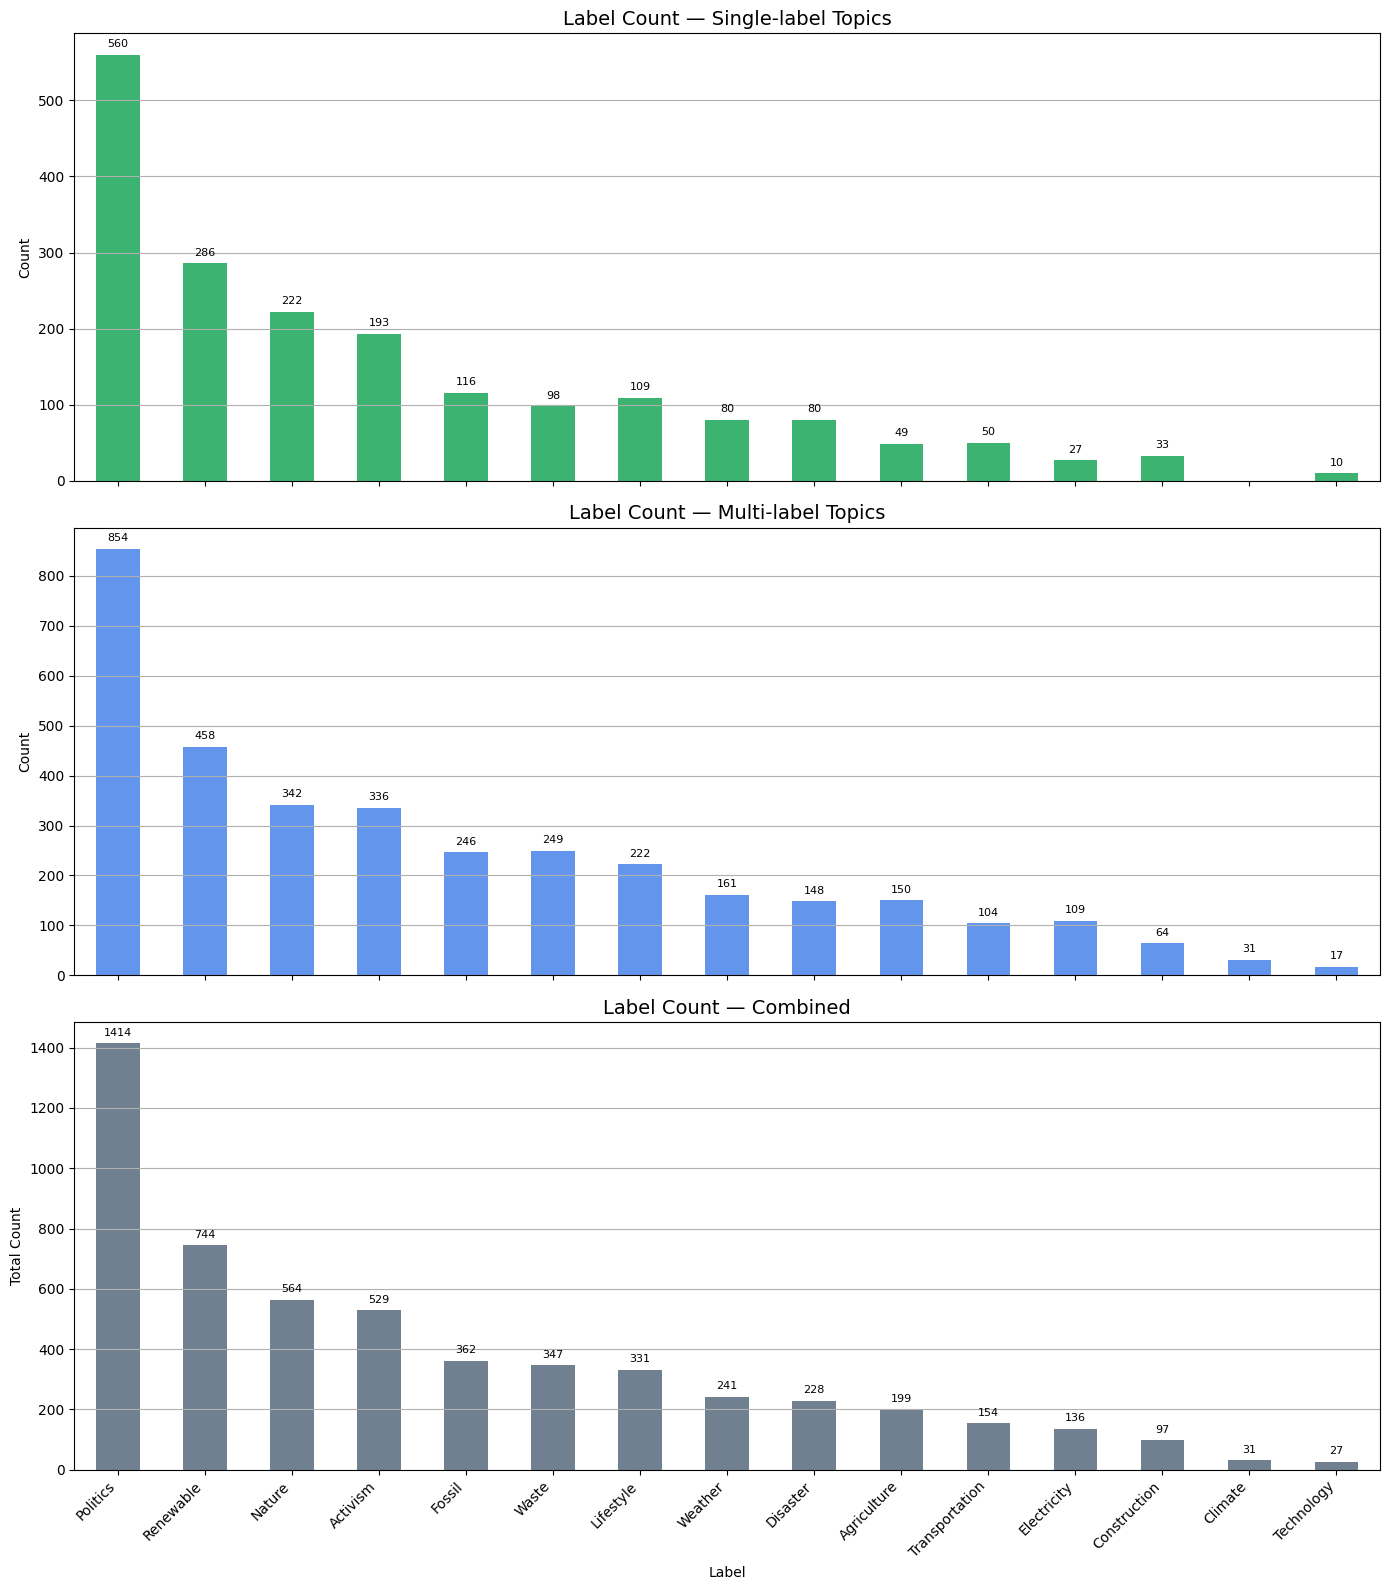

In [161]:
import matplotlib.pyplot as plt

# Helper to add value labels on bars
def annotate_bars(ax):
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f"{int(height)}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

# 1. Separate data
df_single = df_final[df_final["mode"] == "single_label"]
df_multi = df_final[df_final["mode"] == "multi_label"]
counts_single = df_single[labels_to_keep].sum()
counts_multi = df_multi[labels_to_keep].sum()
counts_combined = df_final[labels_to_keep].sum()

# 2. Plot setup
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# --- Single Label Plot ---
ax = axes[0]
counts_single.plot(kind="bar", ax=ax, color="mediumseagreen")
ax.set_title("Label Count — Single-label Topics", fontsize=14)
ax.set_ylabel("Count")
ax.grid(axis="y")
annotate_bars(ax)

# --- Multi Label Plot ---
ax = axes[1]
counts_multi.plot(kind="bar", ax=ax, color="cornflowerblue")
ax.set_title("Label Count — Multi-label Topics", fontsize=14)
ax.set_ylabel("Count")
ax.grid(axis="y")
annotate_bars(ax)

# --- Combined Plot ---
ax = axes[2]
counts_combined.plot(kind="bar", ax=ax, color="slategray")
ax.set_title("Label Count — Combined", fontsize=14)
ax.set_ylabel("Total Count")
ax.set_xlabel("Label")
ax.grid(axis="y")
annotate_bars(ax)

# Final formatting
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/var/folders/f3/z043mppd07z6npdj2ch2t1mm0000gn/T/ipykernel_83989/1495031185.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


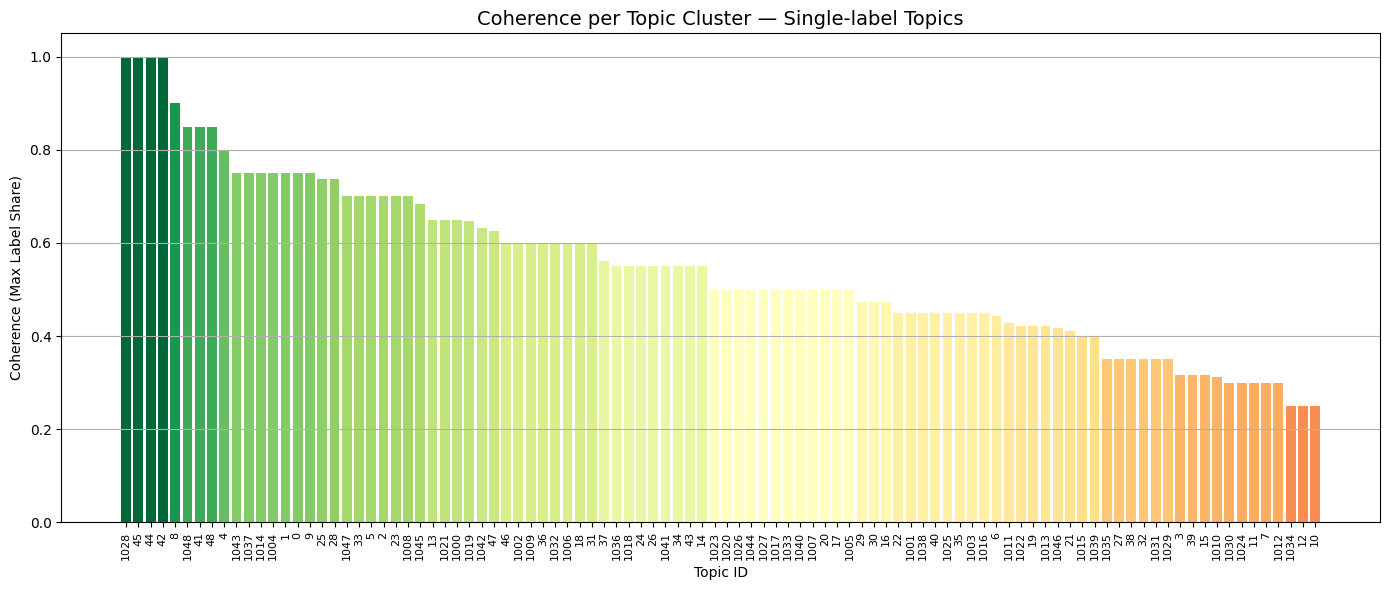

/var/folders/f3/z043mppd07z6npdj2ch2t1mm0000gn/T/ipykernel_83989/1495031185.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')


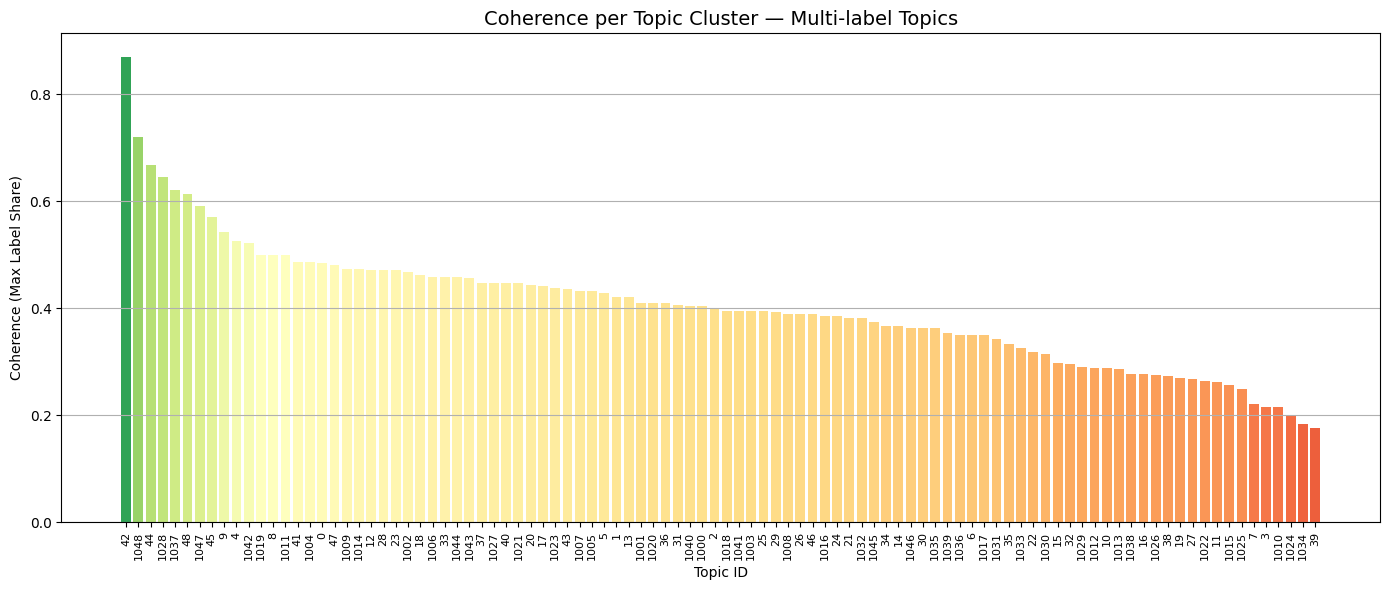

In [162]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Helper function for plotting with colorbar
def plot_coherence_by_mode(df, title, use_mode_prefix=False, figsize=(14, 6)):
    df_sorted = df.sort_values(by="coherence", ascending=False).copy()
    
    # Build topic ID (unique if needed)
    if use_mode_prefix:
        df_sorted["topic_id"] = df_sorted["mode"] + "_" + df_sorted["topic"].astype(str)
        x_labels = df_sorted["topic_id"]
    else:
        x_labels = df_sorted["topic"].astype(str)
    
    # Normalize color scale and get color list
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap('RdYlGn')
    colors = [cmap(norm(val)) for val in df_sorted["coherence"]]

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_labels, df_sorted["coherence"], color=colors)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Topic ID")
    ax.set_ylabel("Coherence (Max Label Share)")
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=90, fontsize=8)
    ax.grid(axis="y")



    plt.tight_layout()
    plt.show()

# 1. Single-label topics
plot_coherence_by_mode(df_final[df_final["mode"] == "single_label"],
                       "Coherence per Topic Cluster — Single-label Topics")

# 2. Multi-label topics
plot_coherence_by_mode(df_final[df_final["mode"] == "multi_label"],
                       "Coherence per Topic Cluster — Multi-label Topics")




## Diversity: How many unique labels are in every cluster?

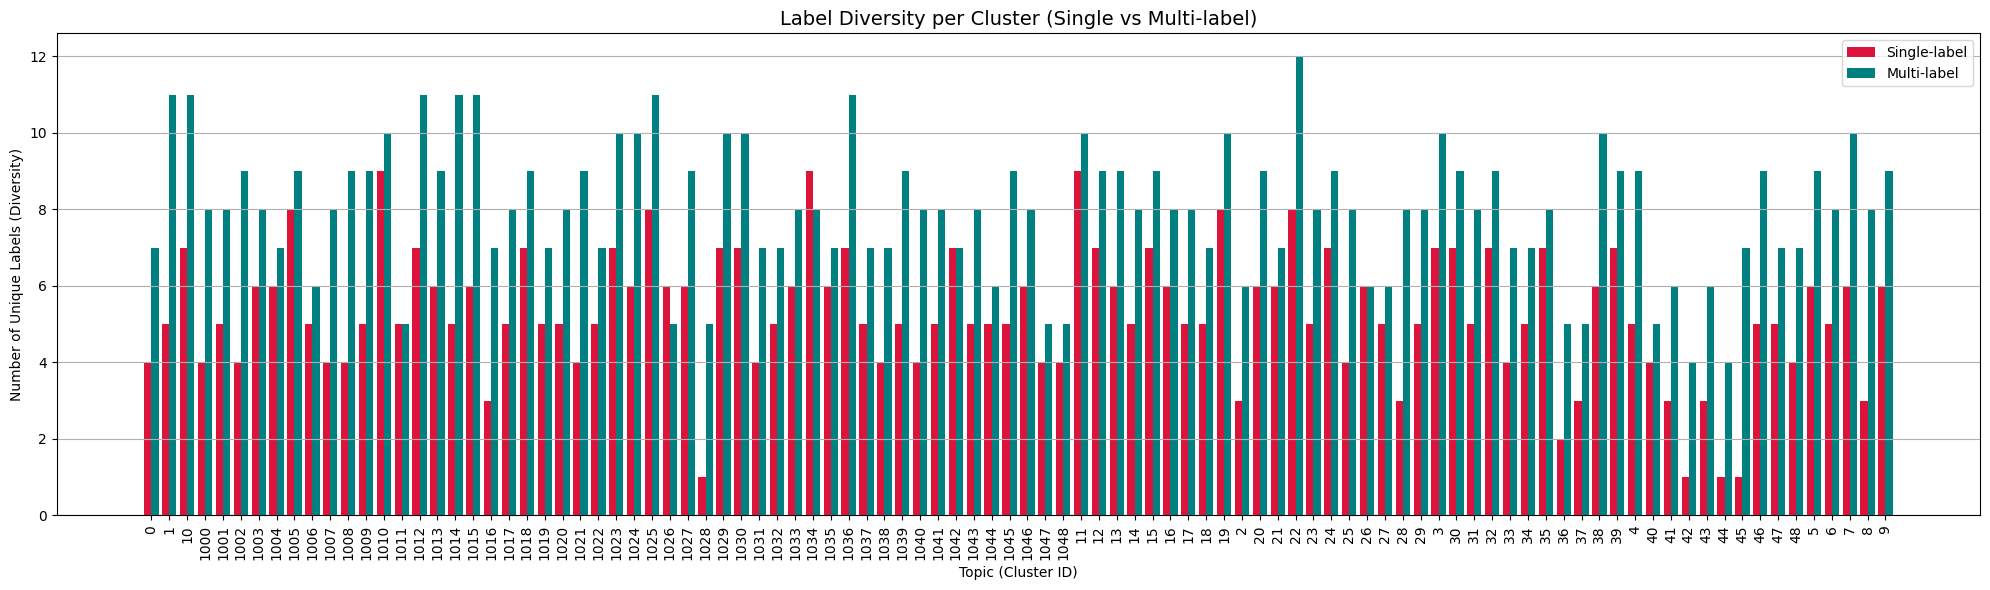

In [163]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by topic for consistent x-axis
df_sorted = df_final.sort_values(by="topic")

# Separate single and multi
df_single = df_sorted[df_sorted["mode"] == "single_label"]
df_multi = df_sorted[df_sorted["mode"] == "multi_label"]

# Shared topics
topics_single = df_single["topic"].astype(str).tolist()
topics_multi = df_multi["topic"].astype(str).tolist()
all_topics = sorted(set(topics_single + topics_multi))

# Prepare bar heights, fill missing with 0
div_single = {str(row["topic"]): row["diversity"] for _, row in df_single.iterrows()}
div_multi = {str(row["topic"]): row["diversity"] for _, row in df_multi.iterrows()}
heights_single = [div_single.get(t, 0) for t in all_topics]
heights_multi = [div_multi.get(t, 0) for t in all_topics]

# Bar positions
x = np.arange(len(all_topics))
bar_width = 0.4

# Plot
plt.figure(figsize=(20, 6))
plt.bar(x - bar_width/2, heights_single, width=bar_width, label="Single-label", color="crimson")
plt.bar(x + bar_width/2, heights_multi, width=bar_width, label="Multi-label", color="teal")

plt.title("Label Diversity per Cluster (Single vs Multi-label)", fontsize=14)
plt.xlabel("Topic (Cluster ID)")
plt.ylabel("Number of Unique Labels (Diversity)")
plt.xticks(x, all_topics, rotation=90)
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()


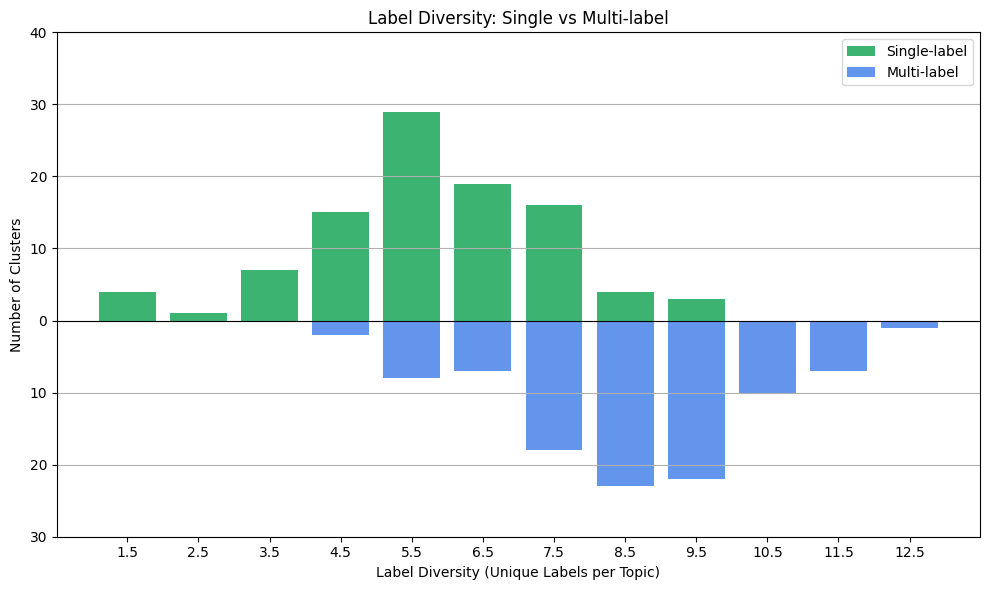

In [164]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
df_single = df_final[df_final["mode"] == "single_label"]
df_multi = df_final[df_final["mode"] == "multi_label"]

# Define bins
max_div = max(df_single["diversity"].max(), df_multi["diversity"].max())
bins = np.arange(1, max_div + 2)

# Histogram counts
single_counts, _ = np.histogram(df_single["diversity"], bins=bins)
multi_counts, _ = np.histogram(df_multi["diversity"], bins=bins)

# Midpoints for bar alignment
bin_centers = bins[:-1] + 0.5

# Plot
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, single_counts, width=0.8, color="mediumseagreen", label="Single-label")
plt.bar(bin_centers, -multi_counts, width=0.8, color="cornflowerblue", label="Multi-label")

# Formatting
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Number of Clusters")
plt.xlabel("Label Diversity (Unique Labels per Topic)")
plt.title("Label Diversity: Single vs Multi-label")
plt.xticks(bin_centers)
plt.grid(axis="y")
plt.legend(loc="upper right")

# Y-axis tick labels as positive numbers
yticks = plt.yticks()[0]
plt.yticks(yticks, [abs(int(y)) for y in yticks])

plt.tight_layout()
plt.show()


## Intra-Label Diversity: How semantically mixed the clusters assigned to a particular label are 

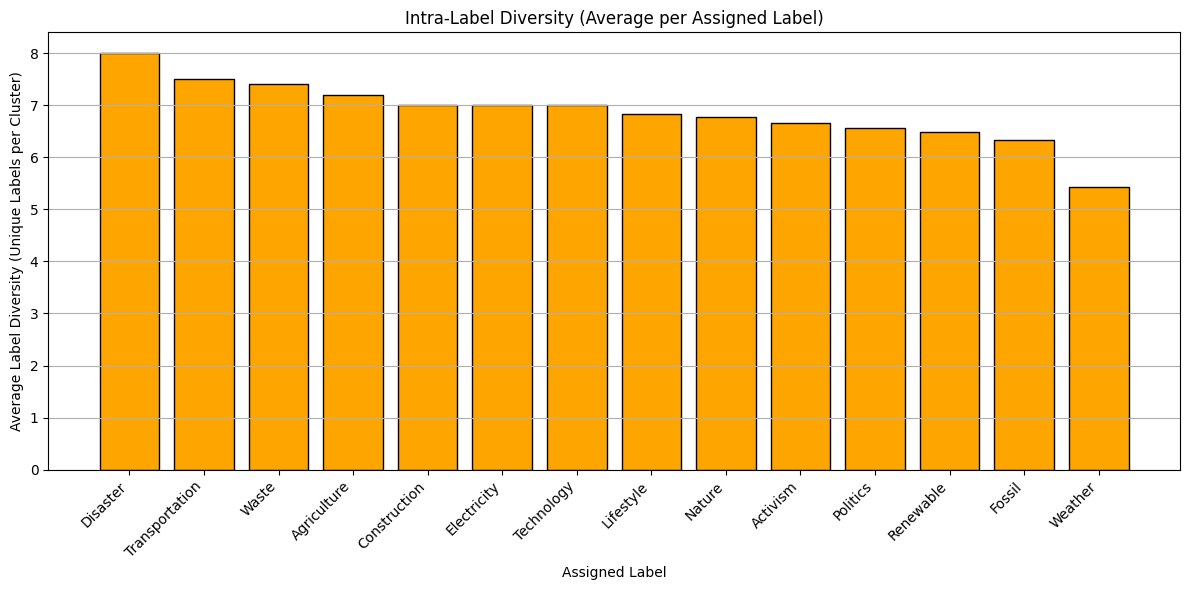

In [165]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure df_final is loaded
# Group by assigned label and compute intra-label stats
intra_label_stats = (
    df_final.groupby("assigned_label")
    .agg(
        num_topics=("topic", "count"),
        avg_diversity=("diversity", "mean"),
        std_diversity=("diversity", "std"),
        avg_coherence=("coherence", "mean")
    )
    .sort_values(by="avg_diversity", ascending=False)
    .reset_index()
)

# Plot: average diversity per label
plt.figure(figsize=(12, 6))
plt.bar(intra_label_stats["assigned_label"], intra_label_stats["avg_diversity"], color="orange", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Label Diversity (Unique Labels per Cluster)")
plt.xlabel("Assigned Label")
plt.title("Intra-Label Diversity (Average per Assigned Label)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [166]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


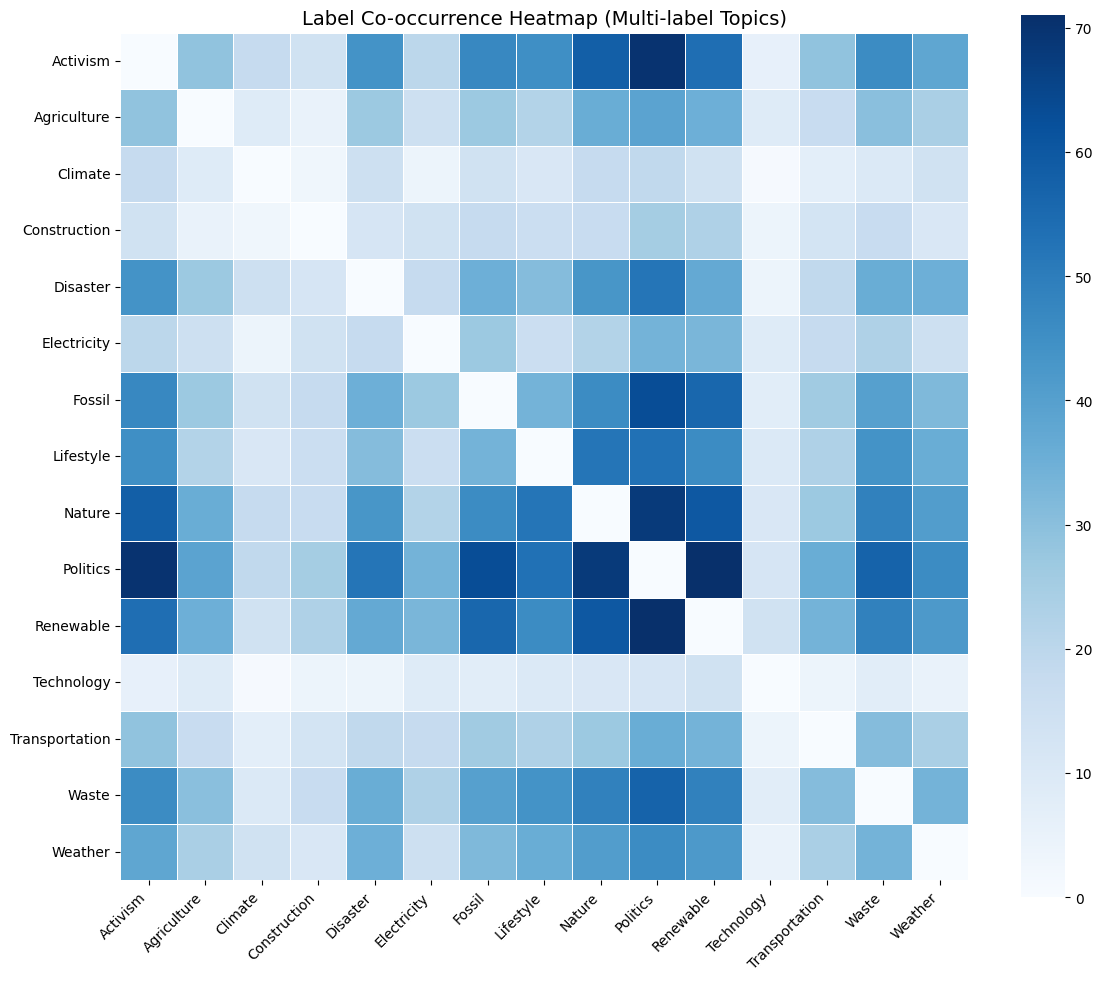

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

df_final = df_filtered
# Step 1: Filter multi-label clusters
df_multi = df_final[df_final["mode"] == "multi_label"]

# Step 2: Count co-occurring label pairs across clusters
cooccur_counter = Counter()

for row in df_multi.itertuples():
    label_dict = row.label_counts
    if isinstance(label_dict, str):
        label_dict = eval(label_dict)  # Convert stringified dict if necessary
    labels = list(label_dict.keys())
    if len(labels) > 1:
        for a, b in combinations(sorted(set(labels)), 2):
            cooccur_counter[(a, b)] += 1

# Step 3: Convert to symmetric co-occurrence matrix
labels = sorted(set([l for pair in cooccur_counter for l in pair]))
matrix = pd.DataFrame(0, index=labels, columns=labels)

for (a, b), count in cooccur_counter.items():
    matrix.loc[a, b] += count
    matrix.loc[b, a] += count

# Optional: zero diagonal
for label in labels:
    matrix.loc[label, label] = 0

# Step 4: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, cmap="Blues", linewidths=0.5, square=True)
plt.title("Label Co-occurrence Heatmap (Multi-label Topics)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [173]:
import pandas as pd
from collections import Counter

# Load your BERTopic final results (adjust path)
df = pd.read_json("/Users/tobiasmichelsen/Bachelor_Project/DS_BachelorProject_PH/data/BERTopicResult/BERTopic_final_result.json", lines=True)

# Count how many posts per topic
topic_counts = df["topic"].value_counts().sort_index()

# Print top results
print(topic_counts.head(20))  # or .to_dict() for full mapping

topic_counts.sum()


topic
0     7396
1     7083
2     4820
3     3254
4     3025
5     2789
6     2665
7     2525
8     2514
9     2437
10    2380
11    2349
12    2324
13    1715
14    1682
15    1513
16    1504
17    1393
18    1243
19    1180
Name: count, dtype: int64


90213